<h1><center>Multi-Agent Hierarchical Cooperation using Q-Learning</center></h1>  

This notebook will introduce you to Multi-Agent Hierarchical Reinforcement Learning. We will go over various important concepts such as Cooperation between agents and Hierarchical division of tasks. Make sure you have your fundamentals clear before starting with this tutorial.  

We will make use of a custom-designed stock trading environment wherein our agents will make decisions of buying, selling and holding shares. Apart from kaing decisions about whether to trade or not, our agents will now also make decisions on the extent of trade, i.e- how much to buy and how much to sell. 

## 1. Import Dependencies 

Let's import the relevant libraries which we would be using for our experiments.

In [4]:
#General Imports
import gym
import json
import math
import numpy as np
import pandas as pd
import pickle
import matplotlib as mpl
import matplotlib.pyplot as plt
import yfinance as yf
from Stock_Trade_Env import StockTradingEnv
import random

#Torch and Baseline Imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Normal
from torch.autograd import Variable
from stable_baselines.common.policies import MlpPolicy
from stable_baselines.common.vec_env import DummyVecEnv

checkpoint_name = './Checkpoint-Trade'

#Use GPU
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')

## 2. Create the Custom Environment

If you wish to skip this step, i.e- treat the environment as a black box, feel free to do so.  

It's time to create our reinforcement learning environment wherein our agent will interact with states, i.e- stock price values and recieve rewards for making decisions. As discussed earlier, we will award the agent a high value for making profit and a low value in cases of loss. The value of reward will depend on the amount gained on the net value. 

Given that it is a new step in the tutorials, here is a little background on creating custom environments and the functions required to create them-  
$\rightarrow$ An environment can be initialized by using the $class$ methods. This class would broadly consist of 3 functions and these are $reset$, $step$ and $render$. Let's have a look at them one-by-one.  
$\rightarrow$ The $reset$ function, as the name suggests, will reset the environment to a random state. In terms of our learning setup, it will yield the next price value from the sequence set to the agent.  
$\rightarrow$ The $step$ function will allow the model to take a step in the environment. The function would take the action from the agent as the input and output the $next-state$ and $reward$. Our environment will output another value called $done$ which is a boolean indicating the comletion of an episode.  
$\rightarrow$ The $render$ function will output the progress of the agent in the environment on the screen. This is typically useful for Atari 2600 domain wherein the environment renders $next-states$ as output screens from the game.  

In [1]:
import random
import json
import gym
from gym import spaces
import pandas as pd
import numpy as np

MAX_ACCOUNT_BALANCE = 2147483647
MAX_NUM_SHARES = 2147483647
MAX_SHARE_PRICE = 5000
MAX_OPEN_POSITIONS = 5
MAX_STEPS = 20000

INITIAL_ACCOUNT_BALANCE = 10000


class StockTradingEnv(gym.Env):
    """A stock trading environment for OpenAI gym"""
    metadata = {'render.modes': ['human']}

    def __init__(self, df):
        super(StockTradingEnv, self).__init__()

        self.df = df
        self.reward_range = (0, MAX_ACCOUNT_BALANCE)

        # Actions of the format Buy x%, Sell x%, Hold, etc.
        self.action_space = spaces.Box(
            low=np.array([0, 0]), high=np.array([3, 1]), dtype=np.float16)

        # Prices contains the OHCL values for the last five prices
        self.observation_space = spaces.Box(
            low=0, high=1, shape=(6, 6), dtype=np.float16)
        
    def _next_observation(self):
        # Get the stock data points for the last 5 days and scale to between 0-1
        frame = np.array([
            self.df.loc[self.current_step: self.current_step +
                        5, 'Open'].values / MAX_SHARE_PRICE,
            self.df.loc[self.current_step: self.current_step +
                        5, 'High'].values / MAX_SHARE_PRICE,
            self.df.loc[self.current_step: self.current_step +
                        5, 'Low'].values / MAX_SHARE_PRICE,
            self.df.loc[self.current_step: self.current_step +
                        5, 'Close'].values / MAX_SHARE_PRICE,
            self.df.loc[self.current_step: self.current_step +
                        5, 'Volume'].values / MAX_NUM_SHARES,
        ])

        # Append additional data and scale each value to between 0-1
        obs = np.append(frame, [[
            self.balance / MAX_ACCOUNT_BALANCE,
            self.max_net_worth / MAX_ACCOUNT_BALANCE,
            self.shares_held / MAX_NUM_SHARES,
            self.cost_basis / MAX_SHARE_PRICE,
            self.total_shares_sold / MAX_NUM_SHARES,
            self.total_sales_value / (MAX_NUM_SHARES * MAX_SHARE_PRICE),
        ]], axis=0)

        return obs

    def _take_action(self, action):
        # Set the current price to a random price within the time step
        current_price = random.uniform(
            self.df.loc[self.current_step, "Open"], self.df.loc[self.current_step, "Close"])

        action_type = action[0]
        amount = action[1]
        
        if action_type < 1:
            # Buy amount % of balance in shares
            total_possible = int(self.balance / current_price)
            shares_bought = int(total_possible * amount)
            prev_cost = self.cost_basis * self.shares_held
            additional_cost = shares_bought * current_price

            self.balance -= additional_cost
            self.cost_basis = (
                prev_cost + additional_cost) / (self.shares_held + shares_bought)
            self.shares_held += shares_bought

        elif action_type < 2:
            # Sell amount % of shares held
            shares_sold = int(self.shares_held * amount)
            self.balance += shares_sold * current_price
            self.shares_held -= shares_sold
            self.total_shares_sold += shares_sold
            self.total_sales_value += shares_sold * current_price

        self.net_worth = self.balance + self.shares_held * current_price

        if self.net_worth > self.max_net_worth:
            self.max_net_worth = self.net_worth

        if self.shares_held == 0:
            self.cost_basis = 0

    
    def step(self,action):
        # Execute one time step within the environment
        self._take_action(action)

        self.current_step += 1

        if self.current_step > len(self.df.loc[:, 'Open'].values) - 6:
            self.current_step = 0

        delay_modifier = (self.current_step / MAX_STEPS)

        reward = self.balance * delay_modifier
        done = self.net_worth <= 0

        obs = self._next_observation()
        
        return obs, reward, done, {}

    def reset(self):
        # Reset the state of the environment to an initial state
        self.balance = INITIAL_ACCOUNT_BALANCE
        self.net_worth = INITIAL_ACCOUNT_BALANCE
        self.max_net_worth = INITIAL_ACCOUNT_BALANCE
        self.shares_held = 0
        self.cost_basis = 0
        self.total_shares_sold = 0
        self.total_sales_value = 0

        # Set the current step to a random point within the data frame
        self.current_step = random.randint(
            0, len(self.df.loc[:, 'Open'].values) - 6)

        return self._next_observation()

    def render(self, mode='human', close=False):
        # Render the environment to the screen
        profit = self.net_worth - INITIAL_ACCOUNT_BALANCE
#         print(f'Step: {self.current_step}')
#         print(f'Balance: {self.balance}')
#         print(
#             f'Shares held: {self.shares_held} (Total sold: {self.total_shares_sold})')
#         print(
#             f'Avg cost for held shares: {self.cost_basis} (Total sales value: {self.total_sales_value})')
#         print(
#             f'Net worth: {self.net_worth} (Max net worth: {self.max_net_worth})')
#         print(f'Profit: {profit}')
        return self.balance, self.shares_held, self.total_shares_sold, self.cost_basis, self.total_sales_value, self.net_worth, profit
        


## 3. Pull Data

Our environment will simulate a real market-like behavior by taking in values from a particular stock. We will download our stock data using the $yfinance$ library and feed it as a dataframe to the environment. 

In [3]:
# ticker_list = ['AAPL','SPOT','FB','GOOGL','MSFT','SPY','NFLX','AMZN','TSLA','KRX','T']
# data = yf.download('SPY MSFT GOOGL FB SPOT AAPL', '2020-01-01', '2020-02-14', interval='2m')
ticker = 'NFLX'
data = yf.download(ticker, '2019-12-30', '2020-02-21', interval='5m')
print(data.shape)
data = data.to_csv('./data.csv')
data = pd.read_csv('./data.csv')

env = DummyVecEnv([lambda: StockTradingEnv(data)])

[*********************100%***********************]  1 of 1 completed
(2807, 6)


K:\Users\Karush Suri\Anaconda3\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float16
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


## 4. Model Instantiation 


### 4.1 Manager Network

We will now make the first part of our agent, the manager network. The manager network will be responsible for making decisions on the bid of the stock, i.e- whether to buy, sell or hold. Input to the manager network will be the state from the environment and output will be one of the action Q-values.  

In terms of the architecture, we will keep our models simple for this tutorial. We will make use of linear layers and instantiate them with ReLU nonlinearities. 

In [5]:
class ActorNetwork(nn.Module): 
    def __init__(self, num_inputs, num_actions, hidden_size, init_w=3e-3):
        super(ActorNetwork, self).__init__()   
        self.linear1 = nn.Linear(num_inputs, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, num_actions)
        self.linear3.weight.data.uniform_(-init_w, init_w)
        self.linear3.bias.data.uniform_(-init_w, init_w)
        
    def forward(self, state): 
        x = F.relu(self.linear1(state))
        x = F.relu(self.linear2(x))
        x = F.tanh(self.linear3(x))
        x = F.softmax(x)
        return x

    def act(self, state, epsilon):
          if random.random() > epsilon:
            state = torch.FloatTensor(state).unsqueeze(0).to(device)
            action = self.forward(state)
            action  = torch.argmax(action,dim=0)
            action = torch.max(action)
          else:
              action = random.randrange(2)
          return action

### 4.3 Order Network

The order network will decide the amount for our bid. Input to the order network will be the state concatenated with the action of the manager network. Output from the order network would be $x$ where $x \in [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]$. Values in the given array indicate the fraction of share to be bought. For instance, if the order network outputs a Q-value of 0.3, it indicates that the network decides to buy/sell 30% of one share of the given stock. 

In [6]:
class OrderNetwork(nn.Module): 
    def __init__(self, num_inputs, num_actions, hidden_size, init_w=3e-3):
        super(OrderNetwork, self).__init__()   
        self.linear1 = nn.Linear(num_inputs, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, num_actions)
        self.linear3.weight.data.uniform_(-init_w, init_w)
        self.linear3.bias.data.uniform_(-init_w, init_w)
        
    def forward(self, state): 
        x = F.relu(self.linear1(state))
        x = F.relu(self.linear2(x))
        x = F.tanh(self.linear3(x))
        x = F.softmax(x)
        return x

    def act(self, state, amount, epsilon):
          if random.random() > epsilon:
            state = torch.FloatTensor(state).unsqueeze(0).to(device)
            action = self.forward(state)
            action  = torch.argmax(action,dim=0)
            action = torch.max(action)
          else:
              action = random.uniform(0,1)
          return action

## 5. Update Rule

Now we will make our update rule for the multi-agent algorithm. We will make use of Q-Learning which updates our parameters based on the best/greedy Q-action value $\underset{a}{max}Q(s^{'},a)$. Here, $s^{'}$ is the next state and $a$ is the action selected. The algorithm can be mathematically expressed as followed-  

$Initialize\qquad Q(s,a), \forall s \in S, \forall a \in A, \qquad Q(term\_state,.) = 0$  
$Repeat(for\quad each\quad episode):$  
$\qquad a,s \leftarrow \pi(s,a)$  
$\qquad execute\quad a$  
$\qquad observe\quad r,s^{'}$  
$\qquad Q(s,a)\leftarrow Q(s,a) + \alpha[r + \gamma\underset{a}{max}Q(s^{'},a) - Q(s,a)]$  
$\qquad s\leftarrow s^{'}$  
$until\quad s\quad is\quad terminal$  

Notice that the update $Q(s,a)\leftarrow Q(s,a) + \alpha[r + \gamma\underset{a}{max}Q(s^{'},a) - Q(s,a)]$ is greedy w.r.t the policy $\pi (s,a)$. Thus, Q-Learning will sample the best action value $\underset{a}{argmax}Q(s,a)$ irrespective of exploration. Hence it is good practice to make the agent explore the environment sufficiently for long-horizon rewards.  

Weight updates for our agents take similar form as the Q-updates-  

<center>$w\leftarrow w + \alpha[r + \gamma\underset{a}{max}Q(s^{'},a,w) - Q(s,a,w)]\nabla Q(s,a,w)$</center>  


For our experiment, we will compute the TD Loss corresponding to each agent as the MSE difference between the Q-value and the expected Q-value ($\underset{a}{max}Q(s^{'},a)$). Mathematically,  

<center>$L = \frac{1}{N}\sum_{i}[Q(s,a) - \underset{a}{max}Q(s^{'},a)]^{2}$</center>

The total loss will be the weighted sum of the manager and order network losses. Feel free to play around with the weight coefficients and see how loss variation progresses.

In [7]:
def compute_td_loss(state,state_order,action,reward,next_state,done):

    action_act = Variable(torch.LongTensor(action[0]))
    action_order = Variable(torch.LongTensor(np.array([action[0,1]])))
    state      = Variable(torch.FloatTensor(np.float32(state)))
    state_order      = Variable(torch.FloatTensor(np.float32(state_order)))
    next_state = Variable(torch.FloatTensor(np.float32(next_state).T), volatile=True)
    reward     = Variable(torch.FloatTensor(reward))
    done       = Variable(torch.FloatTensor(done.astype(int)))
    
    # Manager(Actor) Network
    q_values_act      = policy_net_act(state)
    next_q_values_act = policy_net_act(next_state)
    q_values_act = torch.transpose(q_values_act,1,0)
    q_value_act          = q_values_act.gather(0, action_act.unsqueeze(1)).squeeze(1)
    next_q_value_act     = next_q_values_act.max(1)[0]
    expected_q_value_act = reward + gamma * next_q_value_act * (1 - done)
    act_loss = (q_value_act - Variable(expected_q_value_act.data)).pow(2).mean()
    optimizer_act.zero_grad()
    act_loss.backward()
    optimizer_act.step()

    # Order Network
    q_values_order      = policy_net_order(state_order)
    next_state_order = torch.cat((next_state,next_q_value_act.unsqueeze(0)),1)
    next_q_values_order = policy_net_order(next_state_order)
    q_value_order          = q_values_order.gather(1, action_order.unsqueeze(1)).squeeze(1)
    next_q_value_order     = next_q_values_order.max(1)[0]
    expected_q_value_order = reward + gamma * next_q_value_order * (1 - done) #Should reward be shared?!
    order_loss = (q_value_order - Variable(expected_q_value_order.data)).pow(2).mean()
    optimizer_order.zero_grad()
    order_loss.backward()
    optimizer_order.step()
 
    total_loss = 0.3*act_loss + 0.7*order_loss
    
    return order_loss.detach().cpu().numpy(), act_loss.detach().cpu().numpy(), total_loss.detach().cpu().numpy()

## 6. Test Performance

As usual, we wrtie our main training loop in typical PyTorch style and allow the model to train for a fixed number of frames. We add a new paramter here called $epsilon$ which controls the amount of exploration of the agent. Typically a high starting value of $epsilon$ along with decay would help the agent gain sufficient knowledge of the environment. 

In [9]:
def process(I):
    I = I.astype(np.float).ravel()
    I = np.expand_dims(I,axis=1)
    return I

obs = env.reset()
obs = process(obs)
amount = np.arange(0,1,0.1).tolist()
state_dim_act = len(obs)
state_dim_order = len(obs)+1
action_dim_act = 2
action_dim_order = len(amount)
print('Launching Environment...')

hidden_dim = 128

policy_net_act = ActorNetwork(state_dim_act,action_dim_act,hidden_dim).to(device)
policy_net_order = OrderNetwork(state_dim_order,action_dim_order,hidden_dim).to(device)
policy_lr = 1e-3
optimizer_act = optim.Adam(policy_net_act.parameters(),lr=policy_lr)
optimizer_order = optim.Adam(policy_net_order.parameters(),lr=policy_lr)

TD_Loss = None
load_model = False 
if load_model==True:
  #Load Actor Policy Net
    policy_checkpoint = torch.load(checkpoint_name+'/policy_net_act.pth.tar',map_location='cpu') 
    policy_net_act.load_state_dict(policy_checkpoint['model_state_dict'])
    optimizer_act.load_state_dict(policy_checkpoint['optimizer_state_dict'])
    TD_Loss = policy_checkpoint['loss']
  #Load Order Policy Net
    policy_checkpoint = torch.load(checkpoint_name+'/policy_net_order.pth.tar',map_location='cpu') 
    policy_net_order.load_state_dict(policy_checkpoint['model_state_dict'])
    optimizer_order.load_state_dict(policy_checkpoint['optimizer_state_dict'])
    TD_Loss = policy_checkpoint['loss']

num_frames  = 1000000 #Steps
episodes = [];rewards = [];loss_order = [];loss_actor = [];loss = []
balance = [];profit = [];shares_held = [];shares_sold = [];total_cost = [];total_sales = [];net_value = []
gamma = 0.99

episode_reward = 0
ep_num = 0

epsilon_start = 0.3
epsilon_final = 0.05
epsilon_decay = 30000
epsilon_by_frame = lambda frame_idx: epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * frame_idx / epsilon_decay)

print('Training Started...')
print('-'*100)
state = obs

for frame_idx in range(1, num_frames + 1):
    epsilon = epsilon_by_frame(frame_idx)
    state = state.T
    act = policy_net_act.act(state, epsilon)
    state_order = np.concatenate((state,np.expand_dims(np.array([act]),1)),axis=1)
    order = policy_net_order.act(state_order, amount, epsilon) #Order network should also have knowledge about the action being taken
    action = np.array([act, order])
    action = np.expand_dims(action,axis=1)
    action = action.T
    next_state,reward,done,_ = env.step(action)
    bal, s_held, s_sold, cost, sales, net, prof = env.render()
    next_state = process(next_state)
    
    ord_l, act_l, TD_Loss = compute_td_loss(state,state_order,action,reward,next_state,done)
    
    frame_idx += 1
    state = next_state
    
    if (frame_idx%1000)==0:
        print('Step-', str(frame_idx), '/', str(num_frames), '| Profit-', prof,'| Model Loss-', TD_Loss)
        torch.save({'model_state_dict': policy_net_act.state_dict(), 'optimizer_state_dict': optimizer_act.state_dict(), 'loss': TD_Loss},checkpoint_name+'/policy_net_act.pth.tar') #save PolicyNet
        torch.save({'model_state_dict': policy_net_order.state_dict(), 'optimizer_state_dict': optimizer_order.state_dict(), 'loss': TD_Loss},checkpoint_name+'/policy_net_order.pth.tar') #save PolicyNet
        
    rewards.append(reward),loss.append(TD_Loss),loss_actor.append(act_l),loss_order.append(ord_l)
    balance.append(bal),profit.append(prof),shares_held.append(s_held),shares_sold.append(s_sold),total_cost.append(cost)
    total_sales.append(sales),net_value.append(net)
    
    if done:
        ep_num += 1
        episodes.append(ep_num)
        state = env.reset()
        state = process(state)
        episode_reward = 0
        
data_save = {}
data_save['episode'] = episodes;data_save['reward'] = rewards;data_save['loss'] = loss;data_save['act_loss'] = loss_actor;data_save['order_loss'] = loss_order
data_save['balance'] = balance;data_save['profit'] = profit;data_save['shares_held'] = shares_held;data_save['shares_sold'] = shares_sold
data_save['total_cost'] = total_cost;data_save['total_sales'] = total_sales;data_save['net_value'] = net_value
with open(checkpoint_name+'/data_save.json', 'w') as f: #data+same as frame folder
    json.dump(data, f)

print('-'*100)
print('Training Completed')


Launching Environment...
Training Started...
----------------------------------------------------------------------------------------------------


K:\Users\Karush Suri\Anaconda3\lib\site-packages\torch\nn\functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
K:\Users\Karush Suri\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  
K:\Users\Karush Suri\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys


KeyboardInterrupt: 

## 8. Save Model and Data

In [ ]:

data_save = {}
data_save['reward'] = reward
data_save['profit'] = profit
data_save['net_worth'] = net_worth
data_save['total_sales_value'] = total_sales_value
data_save['cost_basis'] = cost_basis
data_save['total_shares_sold'] = total_shares_sold
data_save['shares_held'] = shares_held
data_save['balance'] = balance

with open(checkpoint_name+'/data_save.pkl', 'wb') as f: #data+same as frame folder
    pickle.dump(data_save, f)

## 9. Plot Results

We will noe plot our results for agent's progress and visualize as to how it performed in the market. 

In [ ]:
#Plot reward and profit
plt.figure(figsize=(15,5))
plt.plot(reward)
plt.plot(profit)
plt.legend(['Reward','Profit'])
plt.show()

#Plot net worth and total sales value
plt.figure(figsize=(15,5))
plt.plot(net_worth)
plt.plot(total_sales_value)
plt.legend(['Net Worth','Total Sales Value'])
plt.show()

#Plot Shares
plt.figure(figsize=(15,5))
plt.plot(shares_held)
plt.plot(total_shares_sold)
plt.legend(['Shares Held','Shares Sold'])
plt.show()

#Plot cost-basis and balance
plt.figure(figsize=(15,5))
plt.plot(cost_basis)
plt.plot(balance)
plt.legend(['Cost Basis','Balance'])
plt.show()

In [1]:
import pickle as pk
import matplotlib.pyplot as plt
import numpy as np

plot = {}
attr = ['profit','net_value','shares_sold']
plot_lst = ['FB','MSFT','GOOGL','SPOT','AAPL','NFLX']

for j in plot_lst:
    dat = pk.load(open("./Checkpoint-Trade/data_"+j+".pkl", "rb"))
    print(j)
    for k in attr:
        plot[j+k] = dat[k]
        plot[j+k] = dat[k]
        plot[j+k] = dat[k]
        plot[j+k] = dat[k]
        plot[j+k] = dat[k]
        plot[j+k] = dat[k]


FB
MSFT
GOOGL
SPOT
AAPL
NFLX


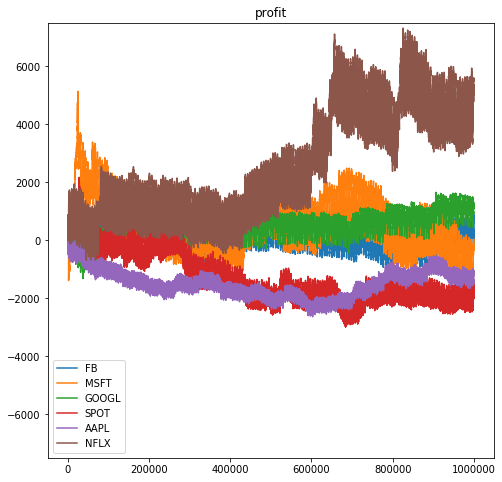

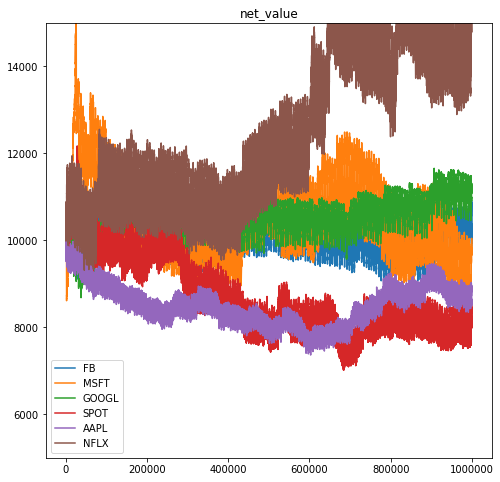

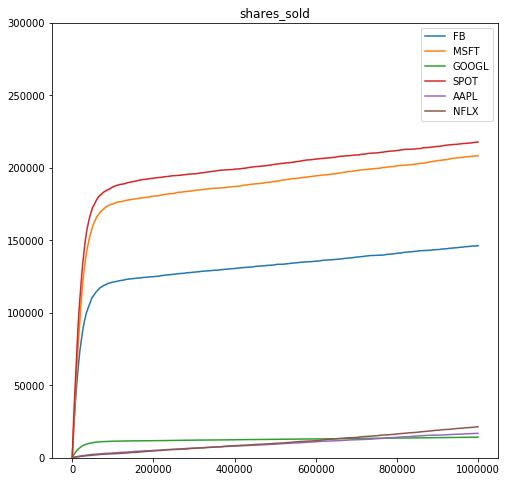

In [4]:

for k in attr:
    plt.figure(figsize=(8,8))
    
    if k==attr[0]:
        plt.ylim(-7500,7500)
    elif k==attr[1]:
        plt.ylim(5000,15000)
    else:
        plt.ylim(0,300000)
    for j in plot_lst:
        plt.title(k)
        plt.plot(plot[j+k])
    plt.legend(plot_lst)
        
